<a href="https://colab.research.google.com/github/hyeonzz/ESAA-23-2/blob/main/10%EC%9B%94_2%EC%9D%BC_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 03-1. 정확도
### 정확도: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
### -> = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit()메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range (X.shape[0],1):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1

        return pred

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/Data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dummy Classifier의 정확도는: 0.6145


#### 단순한 알고리즘으로 예측해도 정확도 결과가 높을 수 있음. -> 정확도를 평가 지표로 사용할 때는 신중해야함. 특히 불균형한 레이블 값 분포에서 모델 성능 판단하면 적합하지 않음.

In [4]:
#MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용시 발생하는 문제

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(Self, X, y):
        pass

    #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X), 1), dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [6]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900000


#### 정확도가 가지는 한계점(불균형한 레이블 데이터 세트에서 성능 평가시)을 극복 -> 여러 가지 분류 지표와 함께 적용해야함.

### 오차행렬
### - True/False, Positive/Negative 의 4분면을로 구성됨.
### - 이진 분류의 예측 오류가 얼마인지 & 어떠한 유형의 예측 오류가 발생하는지 나타내는 지표
### - 4분면의 왼쪽, 오른쪽: 예측된 클래스 값 기준으로 Negative, Positive로 분류
### - 4분면의 위, 아래: 실제 클래스 값 기준으로 Negatibe, Positive로 분류
### - 위아래 기준으로 좌우 4분면 -> TN, FP, FN, TP  
### - 앞의 True/False: 예측값과 실제 값이 '같은가/틀린가'
### - 뒤의 Negative/Positive: 예측 결과 값이 부정(0)/긍정(1)
> #### TN: 예측값을 Negative값 0으로 예측했고 실제 값 역시 Negative 값 0
> #### FP: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative값 0
> #### FN: 예측값을 Negative값 0로 예측했는데 실제 값은 Positive 값 1
> #### TP: 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1


In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

> #### TN: array[0,0] = 405
> #### FP: array[0,1] = 0
> #### FN: array[1,0] = 45
> #### TP: array[1,1] = 0
#### -> 위 값들을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음.
+ #### 정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP) / (TN + Fp + FN + TP)
#### - 일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델 -> 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 Posotove 설정하고 1값 부여함.

### 정밀도와 재현율
#### : Positive 데이터 세트의 예측 성능에 더 초점을 맞춘 평가 지표
* #### 정밀도  = TP / (FP + TP)
> #### = 예측값과 실제값이 Positive로 일치한 데이터 건수 / **예측**을 Positive인 모든 데이터 건수
> ####  예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터 비율
> #### 실제 Negative 음성 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요한 지표로 사용됨.

* #### 재현율 = TP / (FN + TP)
> #### = 예측값과 실제값이 Positive로 일치한 데이터 건수 / **실제값**이 Positive인 모든 데이터 건수
> ####  실제값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
> #### 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요한 지표로 사용됨.

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/Data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
#정밀도에 비해 재현율이 낮게 나옴 -> 재현율 또는 정밀도를 더 강화

### 정밀도/재현율 트레이드오프
#### : 정밀도와 재현율이 상호 보완적인 평가 지표여서 어느 한쪽을 높이면 다른 하나의 수치는 떨어지는 현상
#### predict_proba(): 개별 데이터별로 예측 확률을 반환하는 메서드

In [11]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 shape: {0}'.format(pred_proba.shape))
print('pred_prova array에서 앞 3개만 샘플로 추출 \n:',pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 shape: (179, 2)
pred_prova array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


In [12]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

#predict_proba()반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

#평가 지표 출력함.
get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [14]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
## 임곗값을 낮추니 재현율이 올라가고 정밀도가 떨어짐.

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [15]:
#테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


### precision_recall_curve()
#### - 입력 파라미터 : y_true, probas_pred
#### - 반환 값 : 정밀도, 재현율

In [16]:
from sklearn. metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve인자로 입력
precisions, recalss, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalss[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도: [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


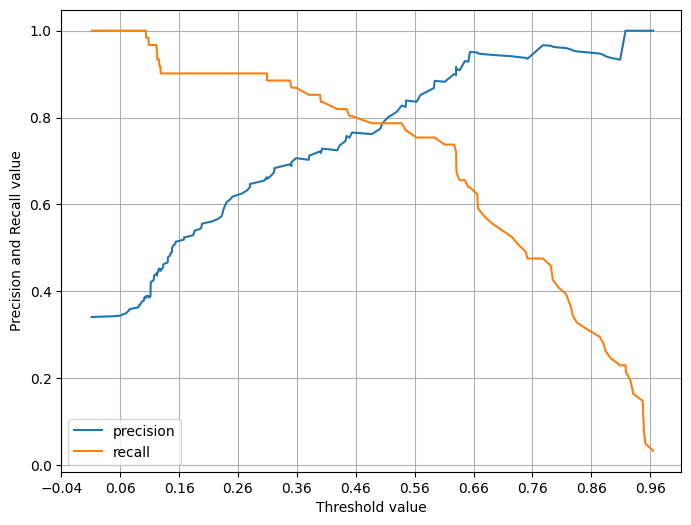

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    #threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### 정밀도와 재현율의 맹점
#### 상호보완적이므로 하나만 강조하는 상황이 되어서는 안 됨.



### F1 스코어

In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [19]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


### ROC 곡선과 AUC

In [20]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


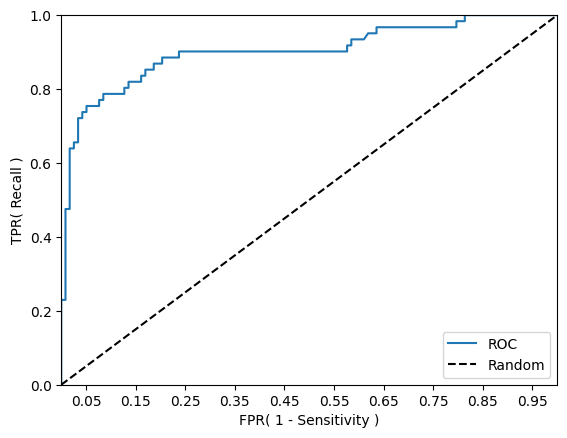

In [21]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k--',label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1);plt.ylim(0,1)
  plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

#print(confusion_matrix(y_target, preds))
#print("정확도:",np.round(accuracy_score(y_target, preds),4))
#print("정밀도:",np.round(precision_score(y_target, preds),4))
#print("재현율:",np.round(recall_score(y_target, preds),4))

In [23]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
  F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))